In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import re
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback, AutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader
import warnings
from transformers import pipeline, AutoTokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Project


# Dataset Cleaning Tweets


In [2]:
# Define columns you want to keep
columns_to_keep = ['date', 'text']

# Create an empty CSV to save the cleaned version
output_file = 'bitcoin_tweets_date_text.csv'
first_chunk = True

for chunk in pd.read_csv('/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/Bitcoin_tweets.csv', chunksize=100000, engine='python'):  
    chunk = chunk[columns_to_keep]
    chunk.to_csv(output_file, mode='a', index=False, header=first_chunk)
    first_chunk = False

In [2]:
df_raw = pd.read_csv("/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/bitcoin_tweets_date_text.csv")

In [3]:
df_raw.head()

,date,text
0,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...
1,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""..."
2,2021-02-10 23:54:48,"Guys evening, I have read this article about B..."
3,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...
4,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...


In [ ]:
# clean df 
df_raw = df_raw.sort_values(by = 'date')
dd = df_raw.sample(frac= 0.05, replace=False, random_state=1)
dd.reset_index(inplace=True)
for i,s in enumerate(tqdm(dd['text'],position=0, leave=True)):
    text = str(dd.loc[i, 'text'])
    text = text.replace("#", "")
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)
    dd.loc[i, 'text'] = text
# f = open(tweets_clean_file, 'a+', encoding='utf-8')
tweets_clean_file = '/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/Bitcoin_tweets_clean.csv'
dd.to_csv(tweets_clean_file, header=True, encoding='utf-8',index=False)

In [5]:
df_clean = pd.read_csv('/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/Bitcoin_tweets_clean.csv')

In [6]:
df_clean.head()

,index,date,text
0,3885516,2022-07-15 13:47:46,Aeron (ARNX) went up 11.6 percent in the last ...
1,984434,2021-08-16 05:15:11,Bitcoin looking bullish👍\n\nA Golden Cross on ...
2,207647,2021-06-21 21:42:06,I have made 23X gain from doge. Now how many X...
3,2529662,2022-03-16 16:05:00,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...
4,552292,2021-07-18 14:28:49,This is definitely going to be HUGE! as the t...


In [7]:
from textblob import TextBlob

df = df_clean.copy()
df = df[['text']] 
df.columns = ['tweets']
df.head()

,tweets
0,Aeron (ARNX) went up 11.6 percent in the last ...
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...
2,I have made 23X gain from doge. Now how many X...
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...
4,This is definitely going to be HUGE! as the t...


In [8]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words(['english'])

print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/farazmustafa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/farazmustafa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/farazmustafa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

def cleaning(data):
    #remove urls
    tweet_without_url = re.sub(r'http\S+',' ', data)

    #remove hashtags
    tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)

    #3. Remove mentions and characters that not in the English alphabets
    tweet_without_mentions = re.sub(r'@\w+',' ', tweet_without_hashtag)
    precleaned_tweet = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)

    #2. Tokenize
    tweet_tokens = TweetTokenizer().tokenize(precleaned_tweet)

    #3. Remove Puncs
    tokens_without_punc = [w for w in tweet_tokens if w.isalpha()]

    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #5. lemma
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]

    #6. Joining
    return " ".join(text_cleaned)

In [10]:
# Clean missing tweets
df['tweets'] = df['tweets'].fillna("")

# Clean tweets
df['cleaned_tweets'] = df['tweets'].apply(cleaning)

# Set date properly
df['date'] = df_clean['date']   # WARNING: make sure df_clean has no weird data
df['date_clean'] = pd.to_datetime(df['date'], errors='coerce').dt.strftime('%Y-%m-%d')

# Drop bad rows where date_clean is NaT
df = df.dropna(subset=['date_clean'])

# Drop old 'date' column
df.drop(columns='date', inplace=True)

# Show result
df.head()


,tweets,cleaned_tweets,date_clean
0,Aeron (ARNX) went up 11.6 percent in the last ...,Aeron ARNX went percent last minute rgEAV yjP ...,2022-07-15
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...,Bitcoin looking bullish A Golden Cross daily t...,2021-08-16
2,I have made 23X gain from doge. Now how many X...,I made X gain doge Now many XXX f cked Bitcoin...,2021-06-21
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...,NEED JOB Sign lVlsl X FREE NO MIDDLEMEN Java P...,2022-03-16
4,This is definitely going to be HUGE! as the t...,This definitely going HUGE team inspiration in...,2021-07-18


### EDA-Tweets

In [11]:
# Create daily tweet aggregation with cleaned data
daily_tweets = df.groupby('date_clean').size().reset_index(name='tweet_count')

# Print daily tweet statistics
print("Daily tweet statistics:")
print(daily_tweets['tweet_count'].describe())

Daily tweet statistics:
count     222.000000
mean     1056.211712
std       758.638716
min         6.000000
25%       322.750000
50%       946.000000
75%      1595.500000
max      3492.000000
Name: tweet_count, dtype: float64


In [12]:
print(df['date_clean'].min())
print(df['date_clean'].max())


2021-02-05
2023-01-09


# Data Bitcoin Prices

In [13]:
import yfinance as yf
import pandas as pd

# Fetch historical Bitcoin prices
def get_btc_prices(start_date='2021-02-05', end_date='2023-01-09'):
    btc = yf.Ticker("BTC-USD")
    df = btc.history(start=start_date, end=end_date)
    return df[['Close', 'Volume']].rename(columns={'Close': 'price'})

# Sentiment Analysis

In [14]:
tokenizer = AutoTokenizer.from_pretrained('ElKulako/cryptobert')
model = AutoModelForSequenceClassification.from_pretrained('ElKulako/cryptobert')
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

def batch_sentiment(texts, batch_size=32):
    sentiments = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        results = sentiment_pipeline(batch)
        sentiments.extend(results)
    return sentiments

Device set to use mps:0


In [15]:
# Apply sentiment analysis
sentiments = batch_sentiment(df['cleaned_tweets'].tolist())
df['sentiment'] = [s['label'] for s in sentiments]
df['sentiment_score'] = [s['score'] for s in sentiments]

In [16]:
df.head()

,tweets,cleaned_tweets,date_clean,sentiment,sentiment_score
0,Aeron (ARNX) went up 11.6 percent in the last ...,Aeron ARNX went percent last minute rgEAV yjP ...,2022-07-15,Neutral,0.512964
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...,Bitcoin looking bullish A Golden Cross daily t...,2021-08-16,Neutral,0.631751
2,I have made 23X gain from doge. Now how many X...,I made X gain doge Now many XXX f cked Bitcoin...,2021-06-21,Bullish,0.684342
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...,NEED JOB Sign lVlsl X FREE NO MIDDLEMEN Java P...,2022-03-16,Neutral,0.738551
4,This is definitely going to be HUGE! as the t...,This definitely going HUGE team inspiration in...,2021-07-18,Bullish,0.543159


## Data Integration

In [18]:
print(df.columns)

Index(['tweets', 'cleaned_tweets', 'date_clean', 'sentiment',
       'sentiment_score'],
      dtype='object')


In [19]:
# Updated function to get multiple crypto prices
def get_crypto_prices(tickers=['BTC-USD'], start_date='2020-01-01', end_date='2023-12-31'):
    data = {}
    for ticker in tickers:
        crypto = yf.Ticker(ticker)
        hist = crypto.history(start=start_date, end=end_date)
        if not hist.empty:
            sym = ticker.split('-')[0]
            # price series
            data[sym] = hist['Close']
            # volume series
            data[f'{sym}_volume'] = hist['Volume']
    return pd.DataFrame(data)

# Get prices for all cryptos
top_cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'ADA-USD', 'SOL-USD', 'XRP-USD']
price_df = get_crypto_prices(top_cryptos)
price_df.index = price_df.index.tz_localize(None).strftime('%Y-%m-%d')
merged_df = pd.merge(df,
                     price_df,
                     left_on='date_clean',
                     right_index=True,
                     how='inner')

# Create target variable (BTC's next day price movement)
merged_df['price_change_btc'] = merged_df['BTC'].pct_change().shift(-1)

# Clean up any missing values
merged_df = merged_df.dropna(subset=['price_change_btc'])

In [20]:
print(merged_df.columns)

Index(['tweets', 'cleaned_tweets', 'date_clean', 'sentiment',
       'sentiment_score', 'BTC', 'BTC_volume', 'ETH', 'ETH_volume', 'BNB',
       'BNB_volume', 'ADA', 'ADA_volume', 'SOL', 'SOL_volume', 'XRP',
       'XRP_volume', 'price_change_btc'],
      dtype='object')


In [21]:
merged_df.head()

,tweets,cleaned_tweets,date_clean,sentiment,sentiment_score,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume,price_change_btc
0,Aeron (ARNX) went up 11.6 percent in the last ...,Aeron ARNX went percent last minute rgEAV yjP ...,2022-07-15,Neutral,0.512964,20836.328125,25905575359,1233.129150,17411448225,238.573990,1151260376,0.442456,739541229,37.415928,1.266227e+09,0.334535,1512184333,1.207898
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...,Bitcoin looking bullish A Golden Cross daily t...,2021-08-16,Neutral,0.631751,46004.484375,32776876610,3156.509521,23080039949,417.470856,2620571467,2.079417,4479074279,62.432465,3.799339e+09,1.190993,8364848221,-0.311443
2,I have made 23X gain from doge. Now how many X...,I made X gain doge Now many XXX f cked Bitcoin...,2021-06-21,Bullish,0.684342,31676.693359,52809038594,1888.447510,33745173825,270.984436,2911962314,1.177480,3987752749,26.657400,7.603445e+08,0.610388,4048720475,0.298871
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...,NEED JOB Sign lVlsl X FREE NO MIDDLEMEN Java P...,2022-03-16,Neutral,0.738551,41143.929688,39616916192,2772.055664,17915109769,385.528229,1788844135,0.838374,1233395707,87.903625,2.370877e+09,0.793538,2480411473,-0.227181
4,This is definitely going to be HUGE! as the t...,This definitely going HUGE team inspiration in...,2021-07-18,Bullish,0.543159,31796.810547,18787986667,1895.552124,13791868728,302.480499,1254819647,1.183698,1354296229,26.751909,2.303364e+08,0.587922,1567538722,-0.067341


### Trading Strategy

In [22]:
def trading_strategy(df, threshold=0.5):
    """Generate trading signals based on sentiment thresholds"""
    df['signal'] = 'HOLD'
    df.loc[df['sentiment_score'] > threshold, 'signal'] = 'BUY'  
    df.loc[df['sentiment_score'] < -threshold, 'signal'] = 'SELL'  
    return df
# Apply strategy
strategy_df = trading_strategy(merged_df.copy())

In [23]:
strategy_df.head()

,tweets,cleaned_tweets,date_clean,sentiment,sentiment_score,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume,price_change_btc,signal
0,Aeron (ARNX) went up 11.6 percent in the last ...,Aeron ARNX went percent last minute rgEAV yjP ...,2022-07-15,Neutral,0.512964,20836.328125,25905575359,1233.129150,17411448225,238.573990,1151260376,0.442456,739541229,37.415928,1.266227e+09,0.334535,1512184333,1.207898,BUY
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...,Bitcoin looking bullish A Golden Cross daily t...,2021-08-16,Neutral,0.631751,46004.484375,32776876610,3156.509521,23080039949,417.470856,2620571467,2.079417,4479074279,62.432465,3.799339e+09,1.190993,8364848221,-0.311443,BUY
2,I have made 23X gain from doge. Now how many X...,I made X gain doge Now many XXX f cked Bitcoin...,2021-06-21,Bullish,0.684342,31676.693359,52809038594,1888.447510,33745173825,270.984436,2911962314,1.177480,3987752749,26.657400,7.603445e+08,0.610388,4048720475,0.298871,BUY
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...,NEED JOB Sign lVlsl X FREE NO MIDDLEMEN Java P...,2022-03-16,Neutral,0.738551,41143.929688,39616916192,2772.055664,17915109769,385.528229,1788844135,0.838374,1233395707,87.903625,2.370877e+09,0.793538,2480411473,-0.227181,BUY
4,This is definitely going to be HUGE! as the t...,This definitely going HUGE team inspiration in...,2021-07-18,Bullish,0.543159,31796.810547,18787986667,1895.552124,13791868728,302.480499,1254819647,1.183698,1354296229,26.751909,2.303364e+08,0.587922,1567538722,-0.067341,BUY


## Model Training

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [25]:
ml_df = merged_df.copy()

In [26]:
ml_df = ml_df.drop(columns=['tweets', 'cleaned_tweets', 'price_change_btc', 'sentiment'])

ml_df.head()

,date_clean,sentiment_score,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume
0,2022-07-15,0.512964,20836.328125,25905575359,1233.129150,17411448225,238.573990,1151260376,0.442456,739541229,37.415928,1.266227e+09,0.334535,1512184333
1,2021-08-16,0.631751,46004.484375,32776876610,3156.509521,23080039949,417.470856,2620571467,2.079417,4479074279,62.432465,3.799339e+09,1.190993,8364848221
2,2021-06-21,0.684342,31676.693359,52809038594,1888.447510,33745173825,270.984436,2911962314,1.177480,3987752749,26.657400,7.603445e+08,0.610388,4048720475
3,2022-03-16,0.738551,41143.929688,39616916192,2772.055664,17915109769,385.528229,1788844135,0.838374,1233395707,87.903625,2.370877e+09,0.793538,2480411473
4,2021-07-18,0.543159,31796.810547,18787986667,1895.552124,13791868728,302.480499,1254819647,1.183698,1354296229,26.751909,2.303364e+08,0.587922,1567538722


In [270]:
crypto_columns = ['BTC', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP']
ml_df[crypto_columns] = ml_df[crypto_columns] / ml_df[crypto_columns].iloc[0]

### Exploratary Data Analysis

In [27]:
ml_df.info()
ml_df.describe()
ml_df.isnull().sum()
ml_df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 234478 entries, 0 to 234653
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date_clean       234478 non-null  object 
 1   sentiment_score  234478 non-null  float64
 2   BTC              234478 non-null  float64
 3   BTC_volume       234478 non-null  int64  
 4   ETH              234478 non-null  float64
 5   ETH_volume       234478 non-null  int64  
 6   BNB              234478 non-null  float64
 7   BNB_volume       234478 non-null  int64  
 8   ADA              234478 non-null  float64
 9   ADA_volume       234478 non-null  int64  
 10  SOL              234478 non-null  float64
 11  SOL_volume       234478 non-null  float64
 12  XRP              234478 non-null  float64
 13  XRP_volume       234478 non-null  int64  
dtypes: float64(8), int64(5), object(1)
memory usage: 26.8+ MB


np.int64(23564)

In [28]:
ml_df['date_clean'] = pd.to_datetime(ml_df['date_clean'])

In [31]:
ml_df.head()

,sentiment_score,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume
date_clean,,,,,,,,,,,,,
2022-07-15,0.512964,20836.328125,25905575359,1233.129150,17411448225,238.573990,1151260376,0.442456,739541229,37.415928,1.266227e+09,0.334535,1512184333
2021-08-16,0.631751,46004.484375,32776876610,3156.509521,23080039949,417.470856,2620571467,2.079417,4479074279,62.432465,3.799339e+09,1.190993,8364848221
2021-06-21,0.684342,31676.693359,52809038594,1888.447510,33745173825,270.984436,2911962314,1.177480,3987752749,26.657400,7.603445e+08,0.610388,4048720475
2022-03-16,0.738551,41143.929688,39616916192,2772.055664,17915109769,385.528229,1788844135,0.838374,1233395707,87.903625,2.370877e+09,0.793538,2480411473
2021-07-18,0.543159,31796.810547,18787986667,1895.552124,13791868728,302.480499,1254819647,1.183698,1354296229,26.751909,2.303364e+08,0.587922,1567538722


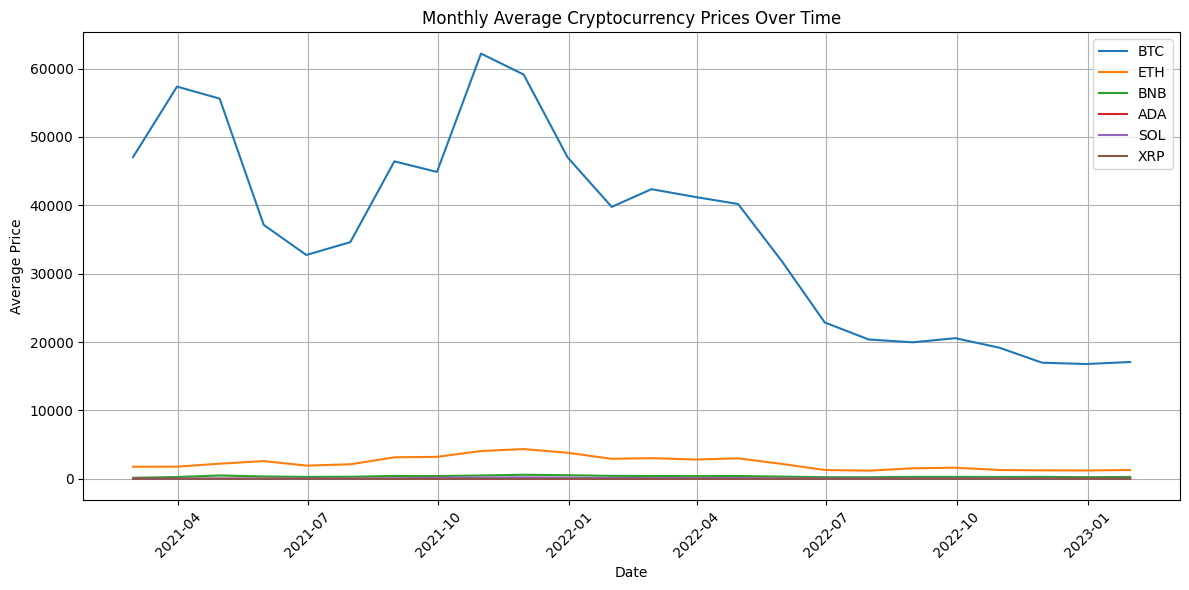

In [34]:
# Aggregate by month (mean)
crypto_columns = ['BTC', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP']
monthly_avg = ml_df[crypto_columns].resample('M').mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
for coin in crypto_columns:
    plt.plot(monthly_avg['date_clean'], monthly_avg[coin], label=coin)

plt.legend()
plt.title('Monthly Average Cryptocurrency Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

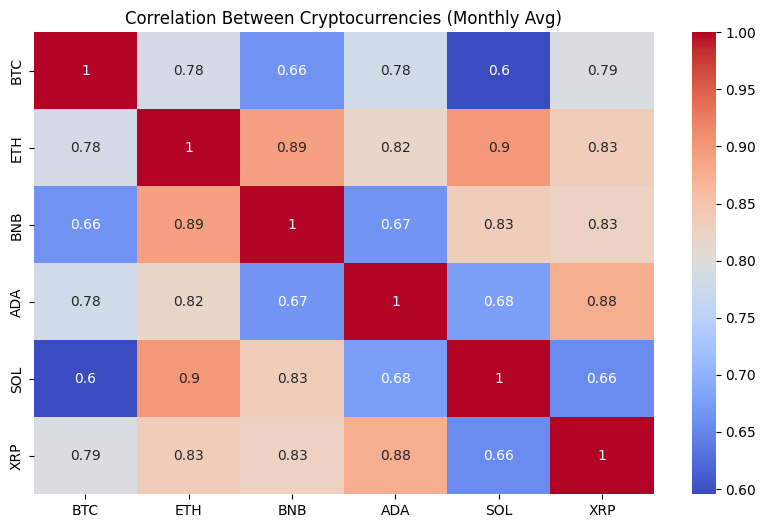

In [35]:
# Recalculate monthly data if needed
monthly_df = ml_df[crypto_columns].resample('M').mean()

plt.figure(figsize=(10, 6))
sns.heatmap(monthly_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Cryptocurrencies (Monthly Avg)')
plt.show()

Number of data points: 24


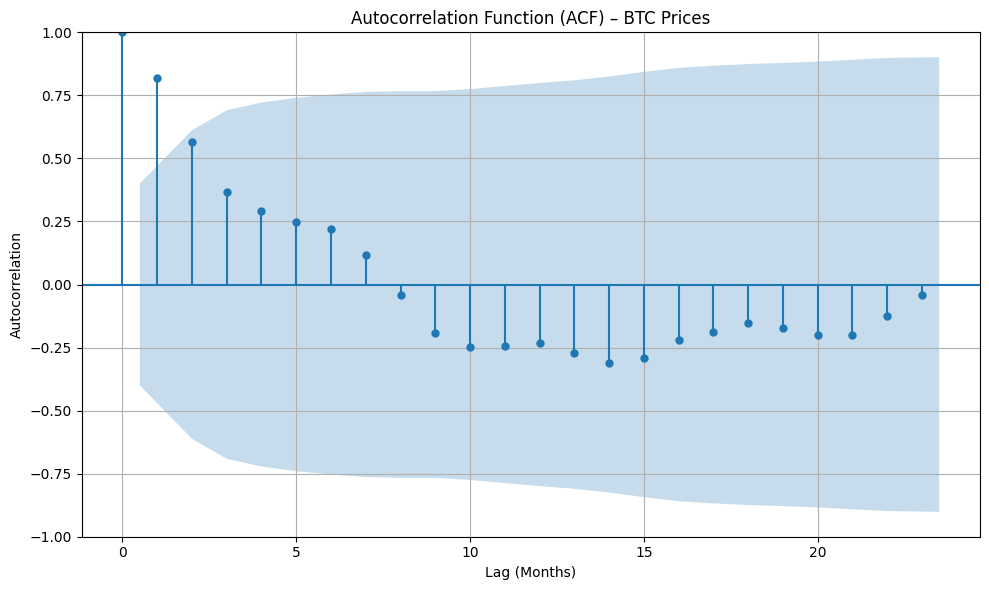

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Resample to monthly average
btc_monthly = ml_df.resample('M').mean()['BTC']

# Check the number of available data points
num_data_points = len(btc_monthly.dropna())
print(f"Number of data points: {num_data_points}")

# Plot ACF with a safe number of lags
plt.figure(figsize=(10, 6))
plot_acf(btc_monthly.dropna(), lags=min(48, num_data_points - 1), ax=plt.gca())
plt.title('Autocorrelation Function (ACF) – BTC Prices')
plt.xlabel('Lag (Months)')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()



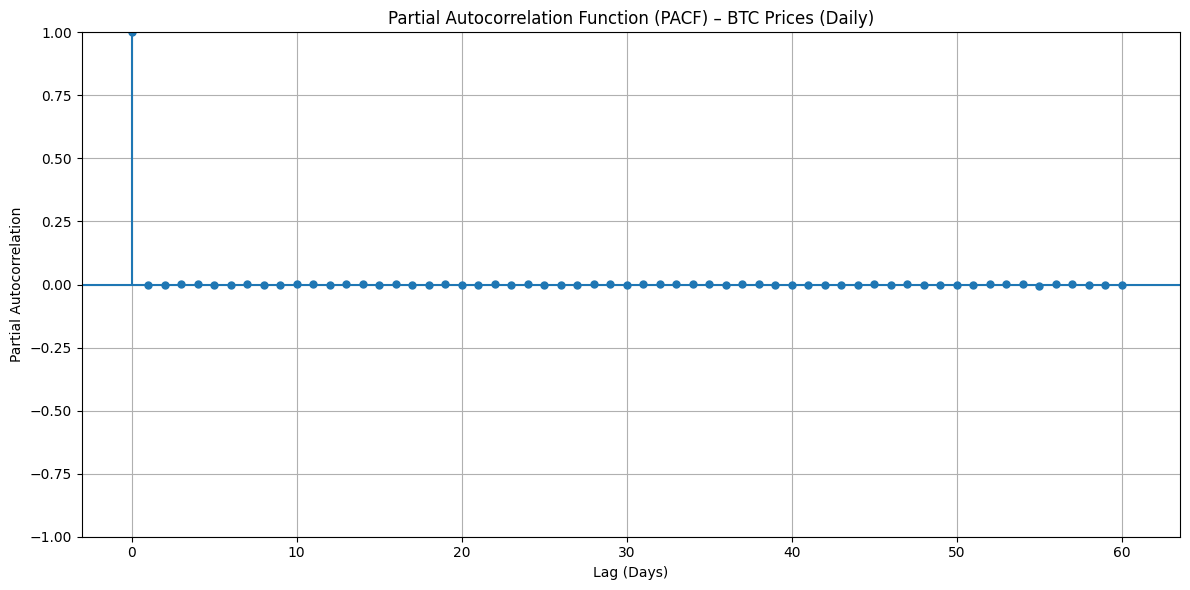

In [38]:
# Resample to monthly average
btc_daily = ml_df['BTC'].dropna()

# Safety check: max allowed lags for PACF is < 50% of data length
max_allowed_lag = (len(btc_daily) // 2) - 1
safe_lag = min(60, max_allowed_lag) 

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(btc_daily, lags=safe_lag, method='ywm', ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) – BTC Prices (Daily)')
plt.xlabel('Lag (Days)')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Feature Importance

            Feature    Importance
5               XRP  6.501084e-01
1               ETH  3.062500e-01
4               SOL  1.774547e-02
3               ADA  1.574469e-02
8        ADA_volume  3.375168e-03
2               BNB  2.306453e-03
10       XRP_volume  2.040999e-03
7        BNB_volume  9.236492e-04
6        ETH_volume  8.523724e-04
9        SOL_volume  6.528038e-04
0   sentiment_score  9.725877e-14


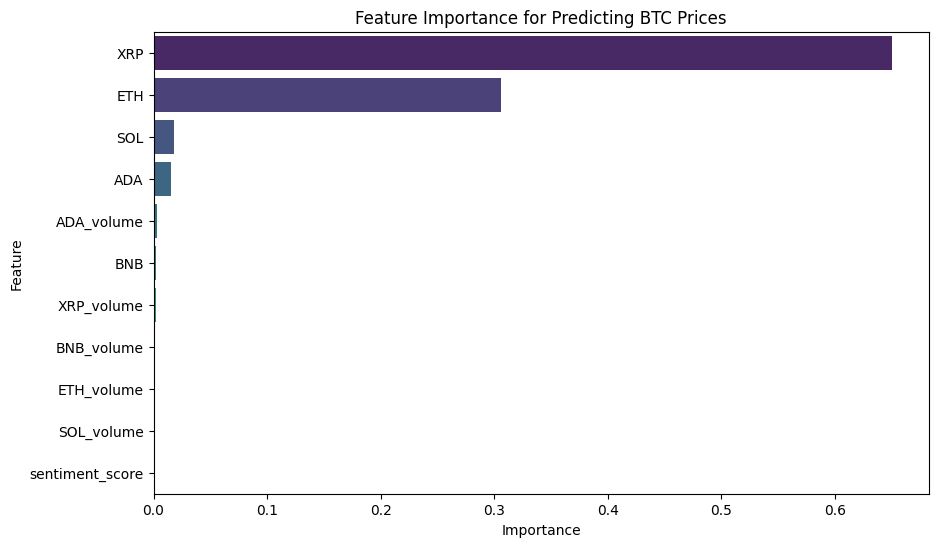

In [39]:
# Define the features (independent variables)
features = ml_df[['sentiment_score', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP', 'ETH_volume', 'BNB_volume', 'ADA_volume', 'SOL_volume', 'XRP_volume']]

# Define the target (dependent variable), e.g., BTC prices
target = ml_df['BTC']

# Train a RandomForest model using the features
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(features, target)

# Extract feature importances and create a DataFrame to visualize
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})

# Sort the features by importance
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print the feature importances
print(importance_df)

# Visualize the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Predicting BTC Prices')
plt.show()

#### Model-Training